In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.io import imread
import seaborn as sns
from tqdm import tqdm
import os

In [2]:
train_dir = 'C:/Ship_Dataset/train_v2/'
test_dir = 'C:/Ship_Dataset/test_v2/'

train = os.listdir(train_dir)
print(len(train))

test = os.listdir(test_dir)
print(len(test))

192556
15606


In [3]:
# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_decode(mask_rle, shape=(768, 768)):
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction

def masks_as_image(in_mask_list):
    all_masks = np.zeros((768, 768), dtype = np.int16)
    for mask in in_mask_list:
        if isinstance(mask, str):
            all_masks += rle_decode(mask)
    return np.expand_dims(all_masks, -1)

In [4]:
masks = pd.read_csv('C:/Ship_Dataset/train_ship_segmentations_v2.csv')
masks.head()

ImageId                                      EncodedPixels
0  00003e153.jpg                                                NaN
1  0001124c7.jpg                                                NaN
2  000155de5.jpg  264661 17 265429 33 266197 33 266965 33 267733...
3  000194a2d.jpg  360486 1 361252 4 362019 5 362785 8 363552 10 ...
4  000194a2d.jpg  51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...

In [5]:
masks = masks[masks['ImageId'].isin(train)]

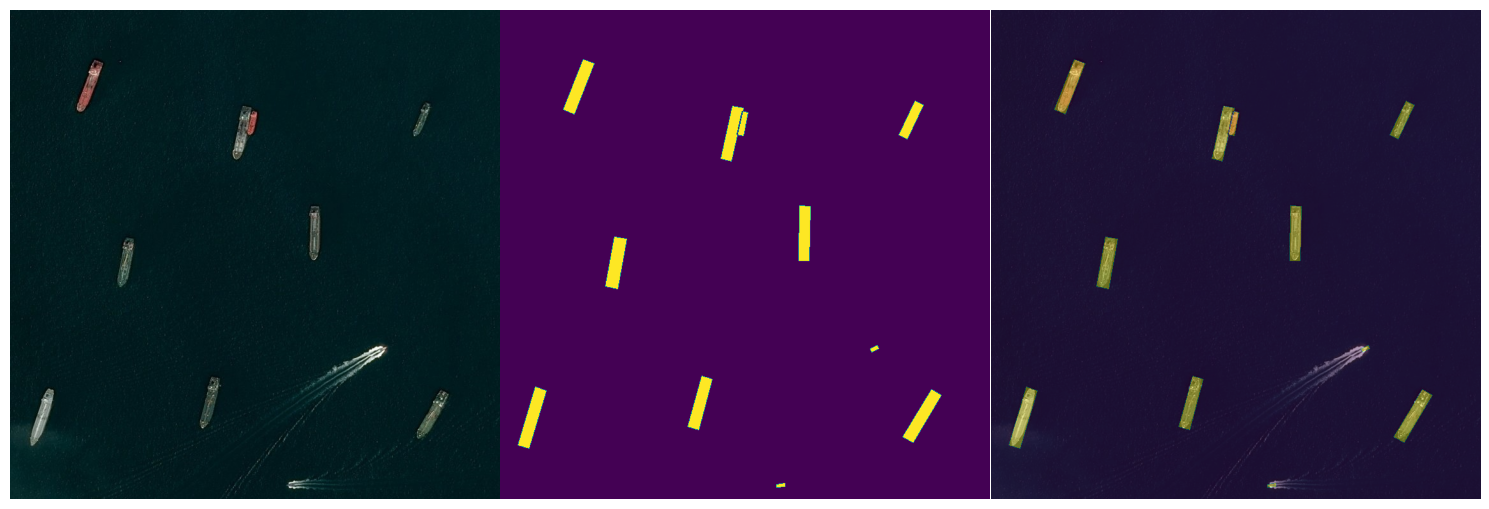

In [6]:
ImageId = '0b1b3d75b.jpg'

img = imread(train_dir + ImageId)
img_masks = masks.loc[masks['ImageId'] == ImageId, 'EncodedPixels'].tolist()

mask = masks_as_image(img_masks)

fig, axarr = plt.subplots(1, 3, figsize=(15, 40))
axarr[0].axis('off')
axarr[1].axis('off')
axarr[2].axis('off')
axarr[0].imshow(img)
axarr[1].imshow(mask)
axarr[2].imshow(img)
axarr[2].imshow(mask, alpha=0.4)
plt.tight_layout(h_pad=0.1, w_pad=0.1)
plt.show()

In [7]:
masks['ships'] = masks['EncodedPixels'].map(lambda c_row: 1 if isinstance(c_row, str) else 0)

images_df = masks.groupby('ImageId').agg({'ships': 'sum'}).reset_index()
images_df['has_ships'] = images_df['ships'].map(lambda x: True if x > 0 else False)

masks.drop(['ships'], axis=1, inplace=True)

images_df.head()

ImageId  ships  has_ships
0  00003e153.jpg      0      False
1  0001124c7.jpg      0      False
2  000155de5.jpg      1       True
3  000194a2d.jpg      5       True
4  0001b1832.jpg      0      False

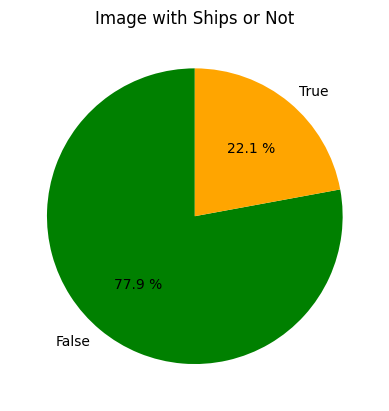

In [8]:
plt.pie(
    x = (images_df['has_ships'].value_counts()/images_df.shape[0]).values, 
    labels = (images_df['has_ships'].value_counts()/images_df.shape[0]).index,
    autopct = '%3.1f %%',
    startangle  = 90,
    colors=['green', 'orange']
)

plt.title('Image with Ships or Not')
plt.show()

In [9]:
images_with_ships_count = images_df['has_ships'].value_counts()[1]
images_withot_ships_count = images_df['has_ships'].value_counts()[0]

sample_to_remove_size = images_withot_ships_count - round(images_with_ships_count * 0.15)
sample_to_remove = images_df.loc[images_df['has_ships'] == False].sample(sample_to_remove_size)

images_df = images_df.drop(sample_to_remove.index)
images_df.shape

(48939, 3)

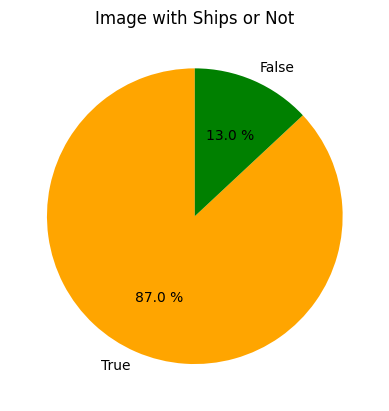

In [10]:
plt.pie(
    x = (images_df['has_ships'].value_counts()/images_df.shape[0]).values, 
    labels = (images_df['has_ships'].value_counts()/images_df.shape[0]).index,
    autopct = '%3.1f %%',
    startangle  = 90,
    colors=['orange', 'green']
)

plt.title('Image with Ships or Not')
plt.show()

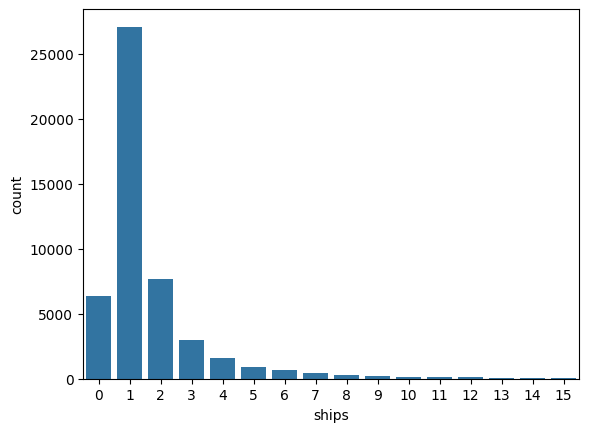

(48939, 3)

In [11]:
sns.countplot(images_df, x='ships')
plt.show()

images_df.shape

In [12]:
from sklearn.model_selection import train_test_split

train_ids, valid_ids = train_test_split(images_df, test_size = 0.02, stratify=images_df['ships'])

train_df = pd.merge(masks, train_ids)
valid_df = pd.merge(masks, valid_ids)
print(train_df.shape[0], 'training masks')
print(valid_df.shape[0], 'validation masks')

86345 training masks
1761 validation masks


In [82]:
from sklearn.model_selection import train_test_split

train_valid_ids, test_ids = train_test_split(images_df, test_size=0.8, stratify=images_df['ships'])

# Потім розділимо train_valid на train і validation набори
train_ids, valid_ids = train_test_split(train_valid_ids, test_size=0.15, stratify=train_valid_ids['ships'])
# 0.25 x 0.8 = 0.2, тому 20% від загальних даних під validation набір

# З'єднуємо маски з train, validation і test наборами
train_df = pd.merge(masks, train_ids)  # замінити "common_column" на назву спільного стовпця
valid_df = pd.merge(masks, valid_ids)
test_df = pd.merge(masks, test_ids)

# Виведення кількості масок у кожному наборі
print(train_df.shape[0], 'training masks')
print(valid_df.shape[0], 'validation masks')
print(test_df.shape[0], 'test masks')


14984 training masks
2641 validation masks
70481 test masks


In [13]:
BATCH_SIZE = 16

In [14]:
import torch
from torch.utils.data import Dataset
from PIL import Image

In [15]:
import albumentations as A
# from albumentations.pytorch import ToTensorV2

def get_augs():
    return A.Compose([
        A.Resize(256, 256)
    ])

In [16]:
class SegmentationDataset(Dataset):

    def __init__(self, in_df, augmentations=None):
        self.df = list(in_df.groupby('ImageId'))
        self.augmentations = augmentations

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        image_name, masks = self.df[idx]
        image_path = os.path.join(train_dir, image_name)

        image = imread(image_path)
        mask = masks_as_image(masks['EncodedPixels'].values)

        if self.augmentations:
            data = self.augmentations(image = image, mask = mask)
            image = data['image']
            mask = data['mask']

        image = np.transpose(image, (2, 1, 0)).astype(np.float32)
        mask = np.transpose(mask, (2, 1, 0)).astype(np.float32)

        image = torch.Tensor(image) / 255.0
        mask = torch.Tensor(mask)

        return image, mask

In [17]:
trainset = SegmentationDataset(train_df, get_augs())
validset = SegmentationDataset(valid_df, get_augs())

In [18]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 47960
Size of Validset : 979


Image shape: torch.Size([3, 256, 256])
Mask shape: torch.Size([1, 256, 256])


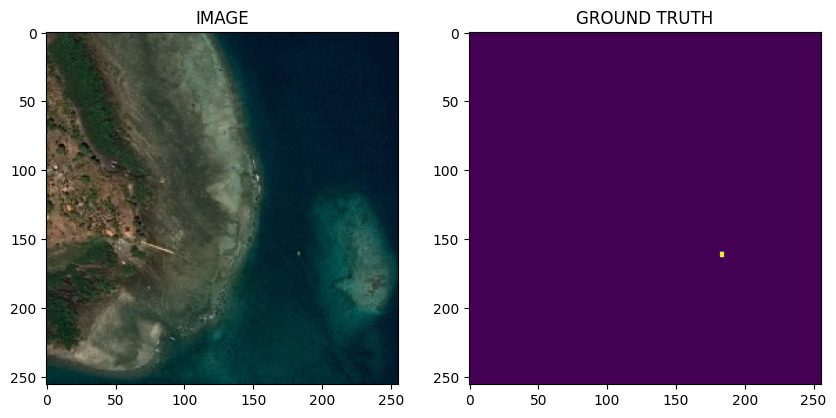

In [20]:
idx = 25

image, mask = trainset[idx]

print(f'Image shape: {image.shape}')
print(f'Mask shape: {mask.shape}')

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image.permute(1, 2, 0))

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask.permute(1, 2, 0))

plt.show()

In [21]:
from torch.utils.data import DataLoader

In [22]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE, pin_memory=True)

In [23]:
print(f'total no. of batches in trainloader : {len(trainloader)}')
print(f'total no. of batches in validloader : {len(validloader)}')

total no. of batches in trainloader : 2998
total no. of batches in validloader : 62


In [24]:
for image, mask in trainloader:
    break

print(f'One batch image shape: {image.shape}')
print(f'One batch mask shape: {mask.shape}')

One batch image shape: torch.Size([16, 3, 256, 256])
One batch mask shape: torch.Size([16, 1, 256, 256])


In [25]:
from torch import nn
import segmentation_models_pytorch as smp

DEVICE = 'cuda'

In [27]:
import torch
import torch.nn as nn
import torchvision.models as models
from segmentation_models_pytorch import Unet

class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None, is_skip_connection=False):
        super(BasicBlock, self).__init__()

        self.relu = nn.ReLU()
        self.initial = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels)
        )

        self.downsample = downsample
        self.is_skip_connection = is_skip_connection


    def forward(self, x):
        out = self.initial(x)

        if self.is_skip_connection:
            if self.downsample is not None:
                x = self.downsample(x)

            out += x

        out = self.relu(out)

        return out

class ResNetEncoder(nn.Module):
    def __init__(self):
        super(ResNetEncoder, self).__init__()

        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.initial = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        self.layer1 = self.make_layer(64, 64, 3)
        self.layer2 = self.make_layer(64, 128, 4, stride=2)
        self.layer3 = self.make_layer(128, 256, 6, stride=2)
        self.layer4 = self.make_layer(256, 512, 3, stride=2)

    def make_layer(self, in_channels, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )

        layers = []
        layers.append(BasicBlock(in_channels, out_channels, stride, downsample, is_skip_connection=True))
        for _ in range(1, blocks):
            layers.append(BasicBlock(out_channels, out_channels, is_skip_connection=True))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.initial(x)
        e1_out = x

        x = self.maxpool(x)
        x = self.layer1(x)
        e2_out = x

        x = self.layer2(x)
        e3_out = x

        x = self.layer3(x)
        e4_out = x

        x = self.layer4(x)

        return x, e1_out, e2_out, e3_out, e4_out

class UpConv(nn.Module):
    def __init__(self, channels):
        super(UpConv, self).__init__()
        
        self.relu = nn.ReLU()
        self.identity = nn.Identity()
        self.up = nn.ConvTranspose2d(channels, channels, kernel_size=2, stride=2)
    
    def forward(self, x):
        x = self.relu(x)
        x = self.identity(x)
        x = self.up(x)
        return x
    
class DecoderBlock(nn.Module):
    def __init__(self, up_channels, in_channels, out_channels):
        super(DecoderBlock, self).__init__()

        self.up = UpConv(up_channels)
        self.block = BasicBlock(in_channels, out_channels)
    
    def forward(self, x, encoder_block_output=None):
        x = self.up(x)

        if encoder_block_output is not None:
            x = self.block(torch.cat([x, encoder_block_output], dim=1))
        else:
            x = self.block(x)
        return x
    
class UnetDecoder(nn.Module):
    def __init__(self):
        super(UnetDecoder, self).__init__()

        self.blocks = nn.ModuleList([
            DecoderBlock(512, 512+256, 256),
            DecoderBlock(256, 256+128, 128),
            DecoderBlock(128, 128+64, 64),
            DecoderBlock(64, 64+64, 32),
            DecoderBlock(32, 32, 16),
        ])
    
    def forward(self, x, e1_out, e2_out, e3_out, e4_out):
        x = self.blocks[0](x, e4_out)
        x = self.blocks[1](x, e3_out)
        x = self.blocks[2](x, e2_out)
        x = self.blocks[3](x, e1_out)
        x = self.blocks[4](x)

        return x

class SegmentationHead(nn.Module):
    def __init__(self):
        super(SegmentationHead, self).__init__()
        self.conv = nn.Conv2d(16, 1, kernel_size=3, padding=1)
        self.activation = nn.Sigmoid()
    
    def forward(self, x):
        x = self.conv(x)
        x = self.activation(x)
        return x

class SegmentationModel(nn.Module):
    def __init__(self, encoder, decoder, segmentation_head):
        super(SegmentationModel, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.segmentation_head = segmentation_head
        self.dice_loss = DiceLoss()

    def forward(self, x):
        x, e1_out, e2_out, e3_out, e4_out = self.encoder(x)
        x = self.decoder(x, e1_out, e2_out, e3_out, e4_out)
        x = self.segmentation_head(x)
        return x

class DiceLoss(nn.Module):
    def forward(self, inputs, targets, smooth=1):
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        intersection = (inputs * targets).sum()
        dice = (2. * intersection + smooth) / (inputs.sum() + targets.sum() + smooth)
        return 1 - dice


encoder = ResNetEncoder()
decoder = UnetDecoder()
segmentation_head = SegmentationHead()

model = SegmentationModel(encoder, decoder, segmentation_head)
model.to(DEVICE);


(dot.exe:2108): Pango-WARNING **: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


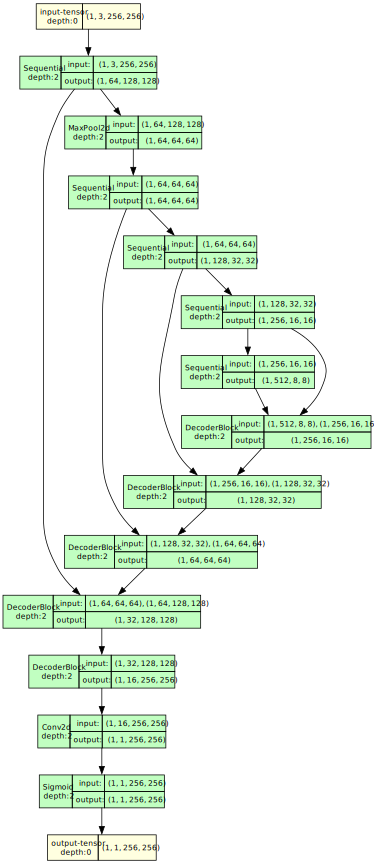

In [28]:
import torchvision
from torchview import draw_graph

model_graph = draw_graph(model, input_size=(1, 3, 256, 256), depth=2)
model_graph.visual_graph

In [29]:
def train_fn(data_loader, model, optimizer, loss_fn):

    model.train()
    total_loss = 0.0

    for images, masks in tqdm(data_loader):

        images = images.to(DEVICE, non_blocking=True)
        masks = masks.to(DEVICE, non_blocking=True)

        optimizer.zero_grad()
        logits = model(images)
        loss = loss_fn(logits, masks)

        loss.backward()
        optimizer.step()

        total_loss += loss.detach().item()
    
    return total_loss / len(data_loader)

def eval_fn(data_loader, model, loss_fn):

    model.eval()
    total_loss = 0.0

    with torch.no_grad():
        for images, masks in tqdm(data_loader):

            images = images.to(DEVICE, non_blocking=True)
            masks = masks.to(DEVICE, non_blocking=True)

            logits = model(images)
            loss = loss_fn(logits, masks)

            total_loss += loss.detach().item()
        
    return total_loss / len(data_loader)

In [36]:
EPOCHS = 5
LR = 0.03

optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [31]:
# model = torch.load('model.pth')
model.load_state_dict(torch.load('best_model.pt'))
model.eval()
model.to('cuda')

SegmentationModel(
  (encoder): ResNetEncoder(
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (initial): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (layer1): Sequential(
      (0): BasicBlock(
        (relu): ReLU()
        (initial): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (1): BasicBlock(
        (relu): ReLU()
        (initial): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 

In [34]:
train_losses = train_losses
valid_losses = valid_losses

In [37]:
best_valid_loss = np.Inf
loss_fn = DiceLoss()

for i in range(EPOCHS):

    train_loss = train_fn(trainloader, model, optimizer, loss_fn)
    valid_loss = eval_fn(validloader, model, loss_fn)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    if valid_loss < best_valid_loss:
        torch.save(model.state_dict(), 'best_model3.pt')
        print('SAVED-MODEL')
        best_valid_loss = valid_loss
    
    print(f'Epoch : {i+1:02} Train_loss : {train_loss:.3f} Valid_loss: {valid_loss:.3f}')

100%|██████████| 62/62 [00:12<00:00,  4.84it/s]


SAVED-MODEL
Epoch : 01 Train_loss : 0.285 Valid_loss: 0.268


100%|██████████| 62/62 [00:12<00:00,  4.88it/s]


SAVED-MODEL
Epoch : 02 Train_loss : 0.278 Valid_loss: 0.259


100%|██████████| 62/62 [00:13<00:00,  4.65it/s]


SAVED-MODEL
Epoch : 03 Train_loss : 0.269 Valid_loss: 0.241


100%|██████████| 62/62 [00:12<00:00,  4.80it/s]


Epoch : 04 Train_loss : 0.262 Valid_loss: 0.245


100%|██████████| 62/62 [00:13<00:00,  4.70it/s]

SAVED-MODEL
Epoch : 05 Train_loss : 0.260 Valid_loss: 0.233


In [42]:
valid_losses

[0.3476212015075068,
 0.3438495455249663,
 0.29004092562583184,
 0.2684546113014221,
 0.25862079281960765,
 0.2412697999708114,
 0.24470131627974973,
 0.2332636252526314]

In [38]:
torch.save(model, 'model2.pth')

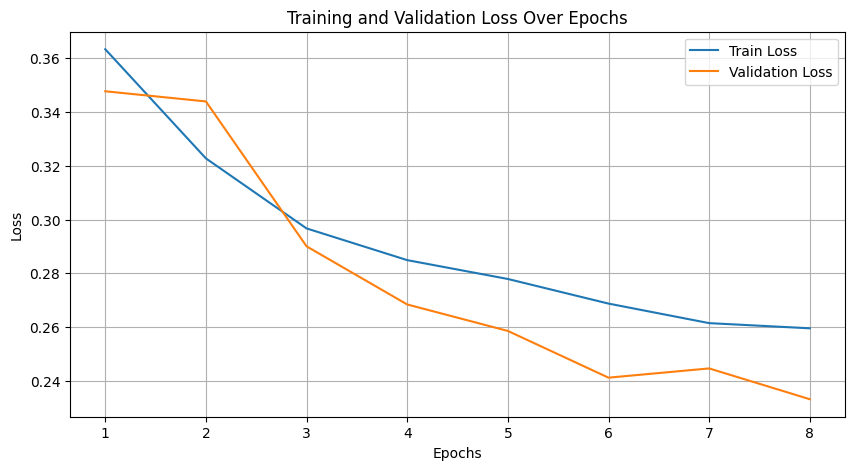

In [46]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, 9), train_losses, label='Train Loss')
plt.plot(range(1, 9), valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.savefig('training_validation_loss.png')
plt.show()

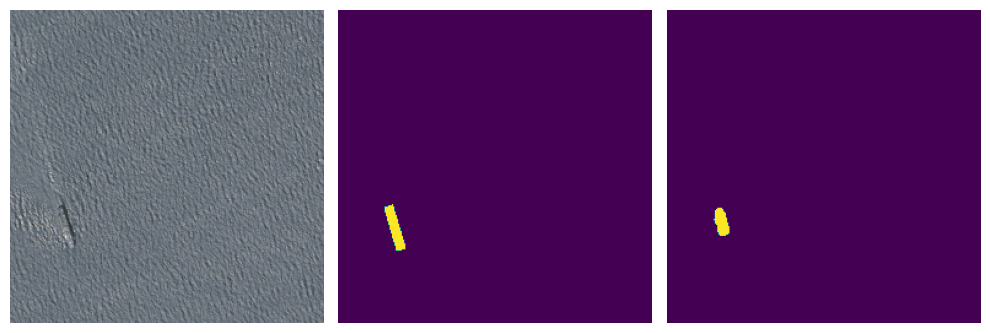

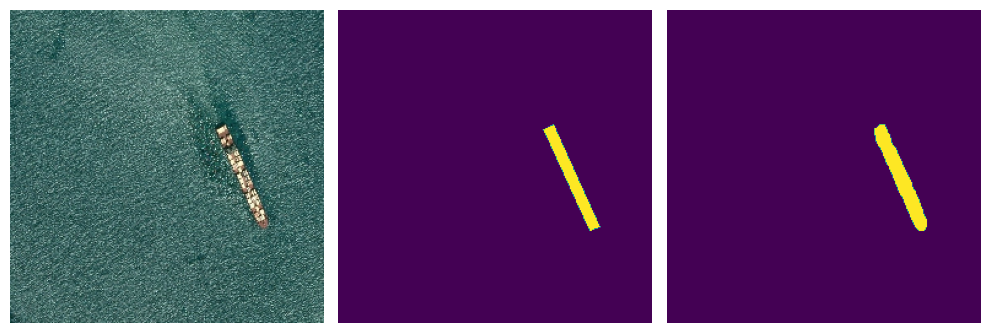

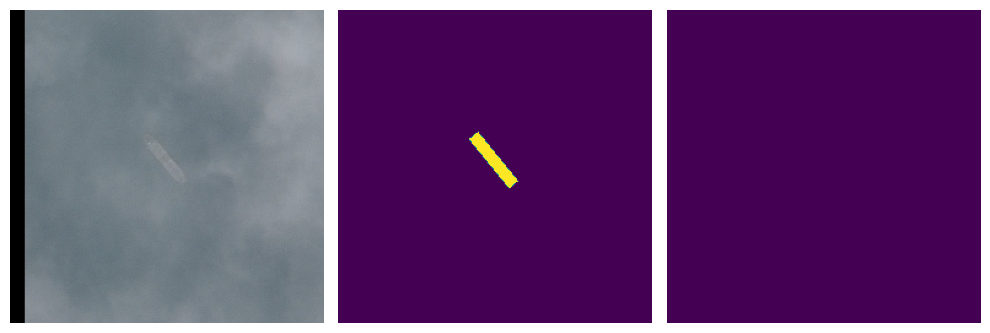

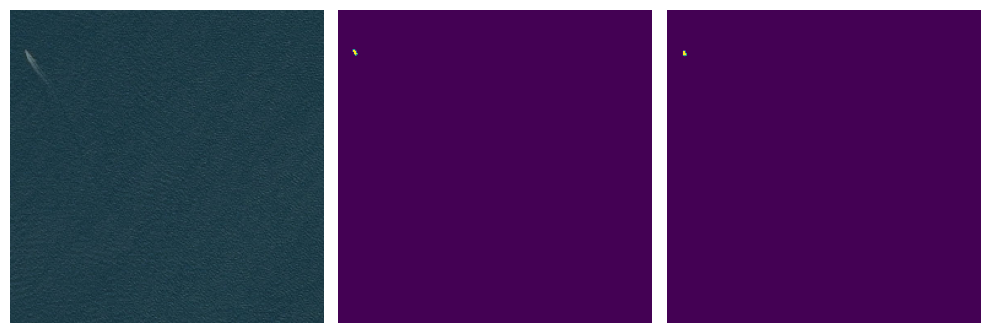

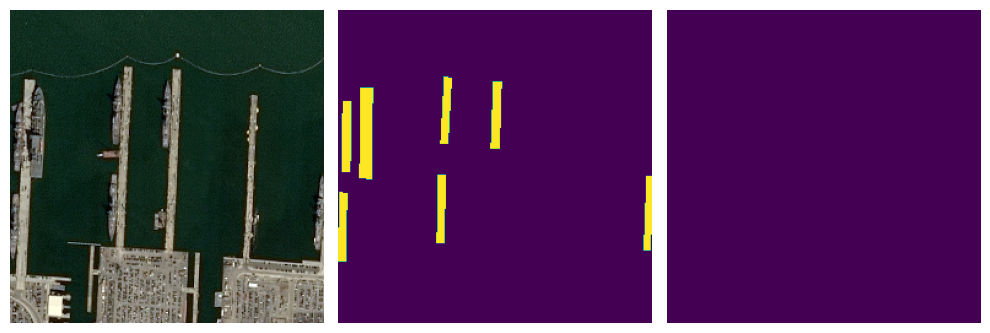

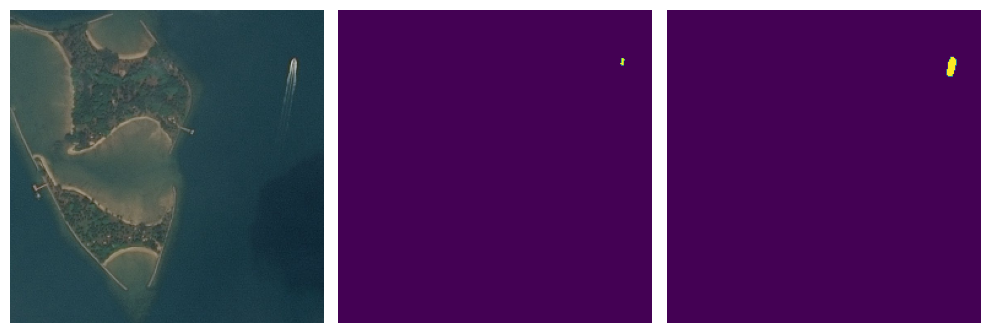

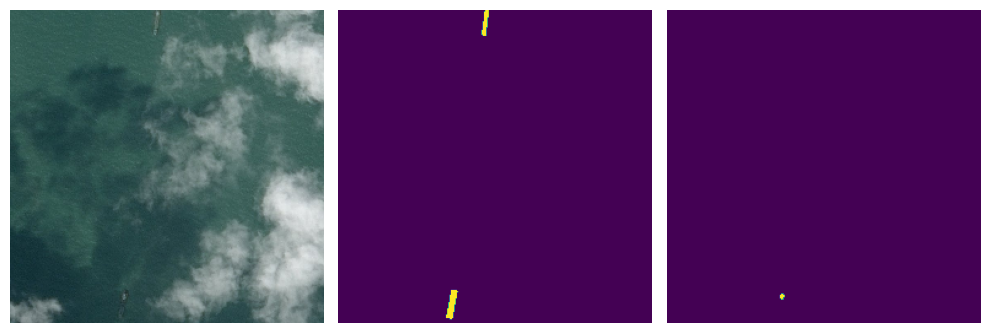

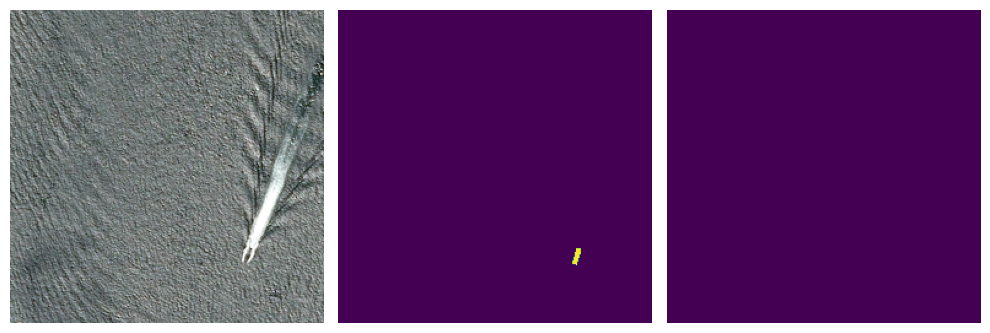

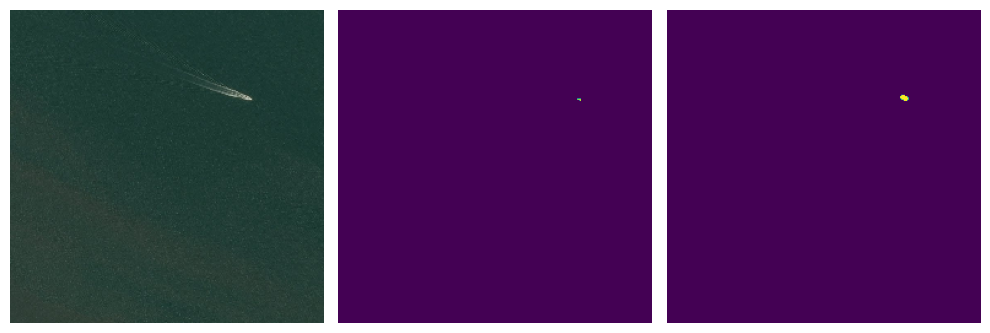

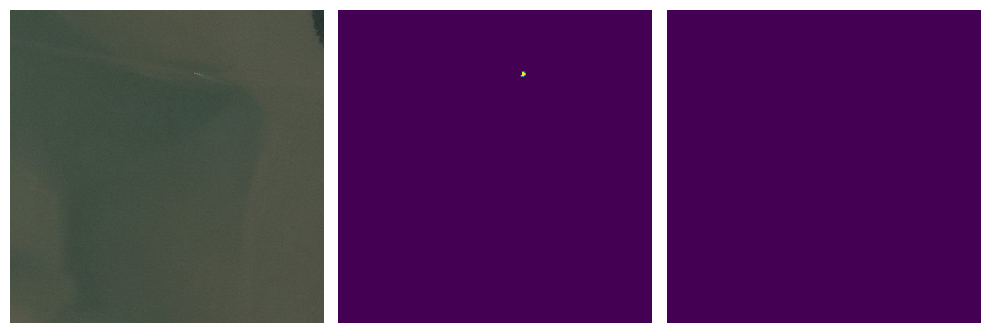

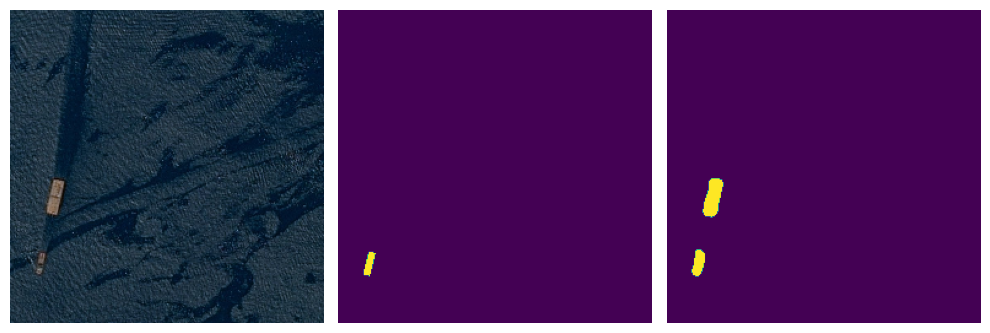

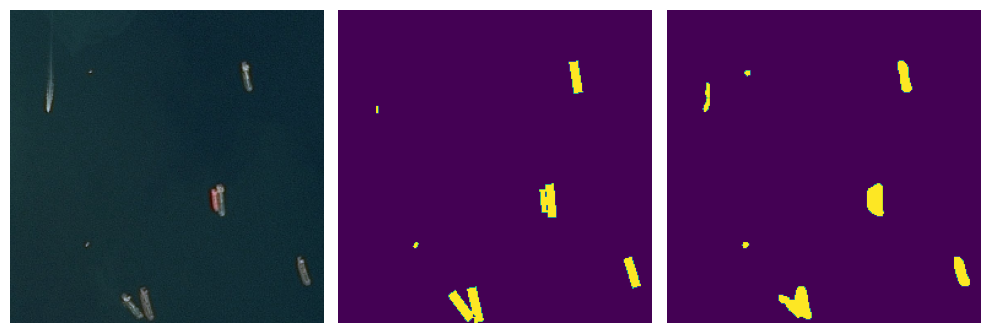

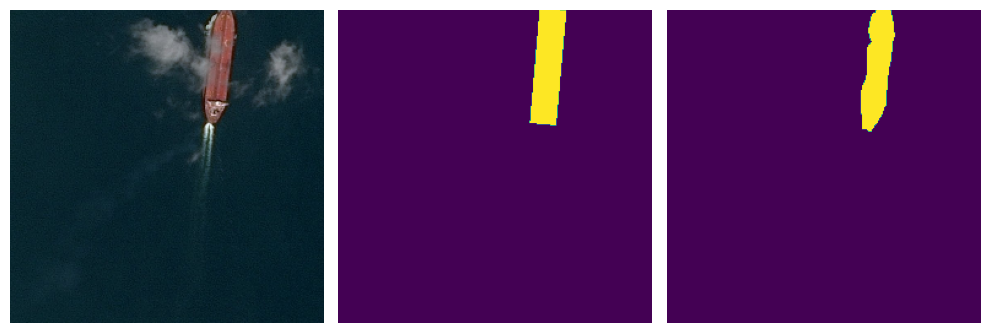

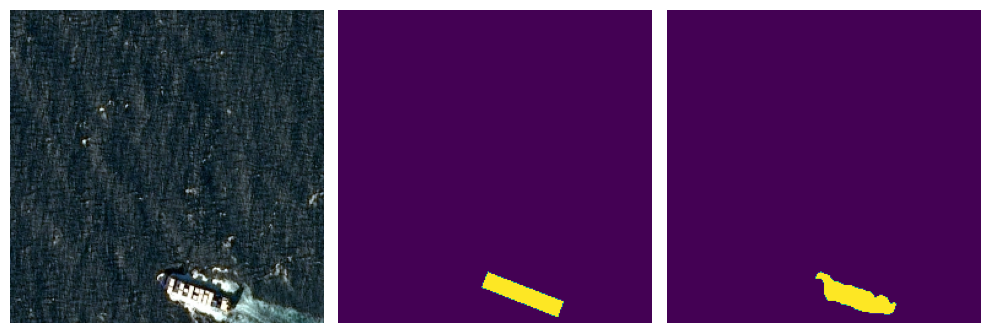

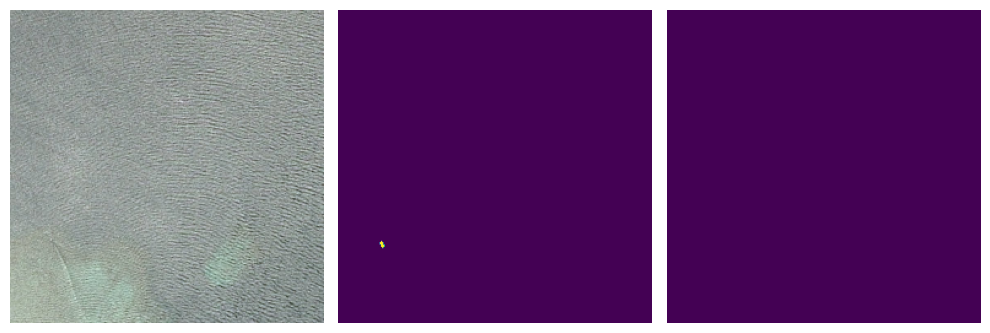

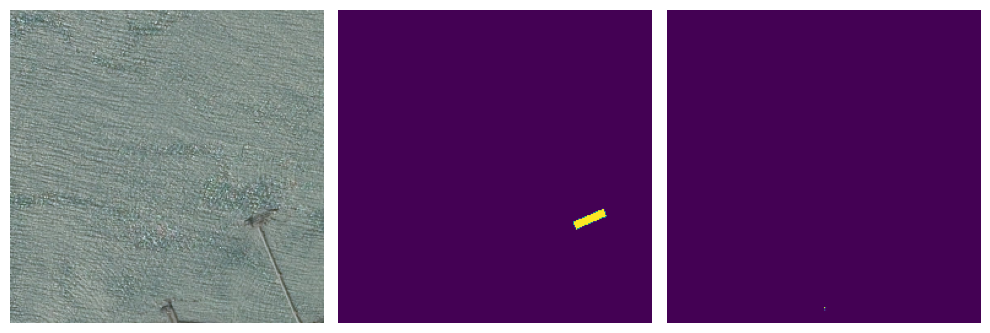

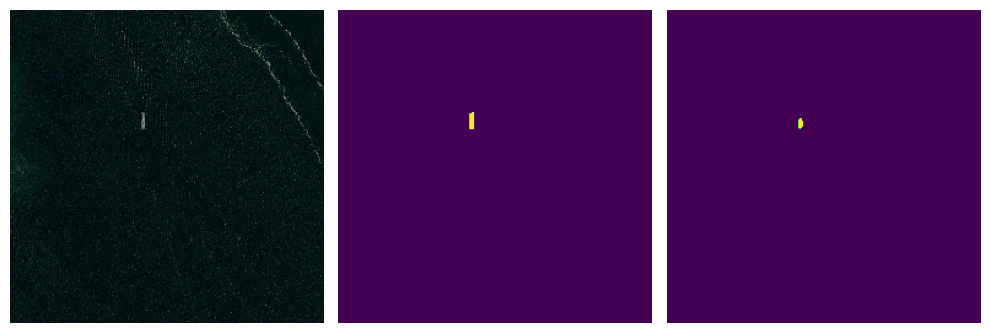

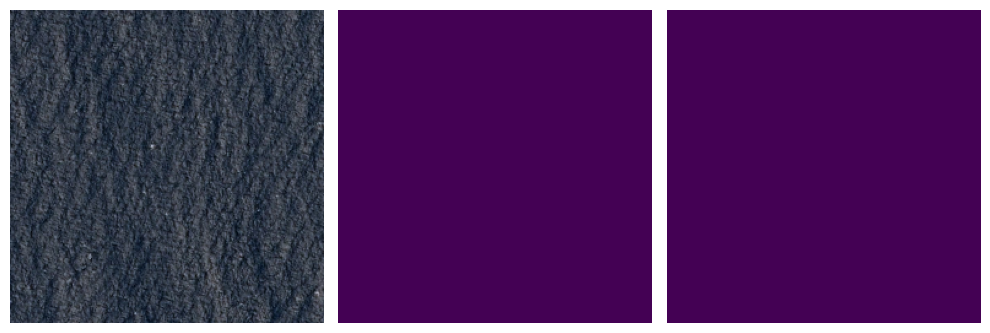

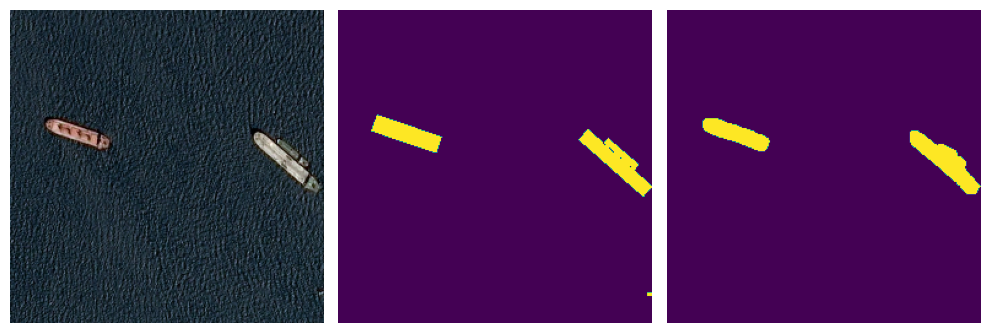

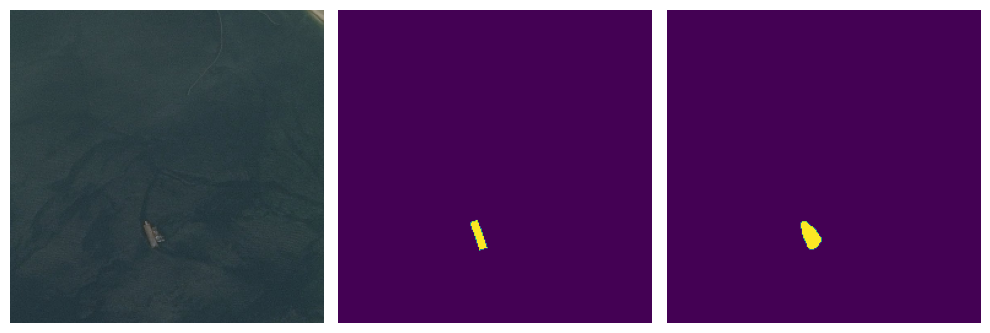

In [39]:
for idx in range(0, 20):
    image, mask = validset[idx]

    logits_mask = model(image.to(DEVICE).unsqueeze(0))
    #pred_mask = torch.sigmoid(logits_mask)
    # pred_mask = (pred_mask > 0.5)*1.0

    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10,5))

    ax1.imshow(image.permute(1, 2, 0))
    ax1.axis('off')

    ax2.imshow(mask.permute(1, 2, 0))
    ax2.axis('off')

    ax3.imshow(logits_mask[0][0].to('cpu').detach().numpy())
    # ax3.imshow(logits_mask[0][0].to('cpu'))
    ax3.axis('off')
    
    plt.tight_layout()
    plt.show()